# Tour Time of Day Distribution

In [2]:
import pandas as pd
import h5py
import math
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
survey_h5 = h5py.File(r'R:\SoundCast\Inputs\2014\etc\survey.h5')
daysim_h5 = h5py.File(r'R:\SoundCast\releases\TransportationFutures2010\outputs\daysim_outputs.h5')

In [4]:
pd.set_option('display.precision', 4)

In [5]:
def h5_to_df(h5file, table_list):
    """
    Load h5-formatted data based on a table list. Assumes heirarchy of a set of tables.
    """
    output_dict = {}
    
    for table in table_list:
        df = pd.DataFrame()
        for field in h5file[table].keys():
            df[field] = h5file[table][field][:]
            
        output_dict[table] = df
        
    return output_dict

In [6]:
# Load subset of a dataframe as needed
def h5_subset(h5file, table, fields):
    df = pd.DataFrame()
    for field in fields:
        df[field] = h5file[table][field][:]

In [7]:
survey = h5_to_df(survey_h5, table_list=['Trip','Tour','Person','HouseholdDay', 'Household'])
daysim = h5_to_df(daysim_h5, table_list=['Trip','Tour','Person','HouseholdDay', 'Household'])
labels_applied = False

## Add Labels

In [8]:
# apply labels all based on table, field, and value
labels = pd.read_csv(r'variable_labels.csv')

# Only run this once, set labels_applied = False in loading 
if not labels_applied:
    for table in labels['table'].unique():
        df = labels[labels['table'] == table]
        for field in df['field'].unique():
            newdf = df[df['field'] == field]
            local_series = pd.Series(newdf['text'].values, index=newdf['value'])
            survey[table][field] = survey[table][field].map(local_series)
            daysim[table][field] = daysim[table][field].map(local_series)

# Only run this once
labels_applied = True

In [9]:
def hhmm_to_mam(df, fields):
    for field in fields:
        df[field+'_hr'] = df[field].apply(lambda row: int(math.floor(row/60)))
    
    return df

In [31]:
def distribution_plot(df1, df2, field, expfac):
    '''
    Plot bar-chart distribution comparison of two similar dataframes along a single field
    e.g., Show trip start time (field='deptm') for survey (df1) vs model (df2), using
    expansion factors (expfac) to weight survey results
    '''
    df = pd.DataFrame([df.groupby(field).sum()[expfac]/df[expfac].sum() for df in [df1,df2]]).T
    df.columns = ['survey','daysim']
    df.plot(kind='bar', figsize=(10,10), alpha=0.7, title=field + ' Distributon')

In [11]:
survey['Tour'] = hhmm_to_mam(survey['Tour'], ['tlvorig','tardest','tlvdest','tarorig'])
daysim['Tour'] = hhmm_to_mam(daysim['Tour'], ['tlvorig','tardest','tlvdest','tarorig'])

In [12]:
# Transit trips
survey_transit_tours = survey['Tour'][survey['Tour']['tmodetp'] == 'Transit']
daysim_transit_tours = daysim['Tour'][daysim['Tour']['tmodetp'] == 'Transit']

# All Modes
## Tour Origin Departure Hour

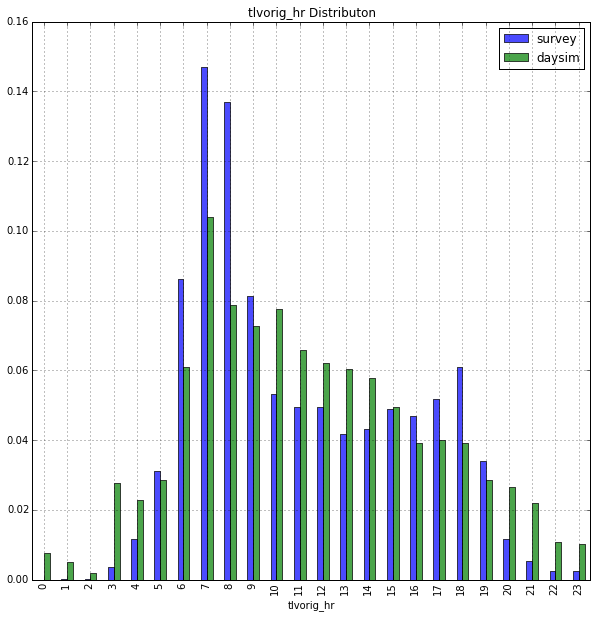

In [32]:
distribution_plot(survey['Tour'], daysim['Tour'], 'tlvorig_hr', expfac='toexpfac')

## All Modes: Tour Origin Departure Hour by Purpose

In [16]:
survey_pivot_df = pd.pivot_table(survey['Tour'],columns='pdpurp', index='tlvorig_hr', values='toexpfac', aggfunc='sum')
survey_pivot_df = survey_pivot_df/(survey_pivot_df.sum())

daysim_pivot_df = pd.pivot_table(daysim['Tour'],columns='pdpurp', index='tlvorig_hr', values='toexpfac', aggfunc='sum')
daysim_pivot_df = daysim_pivot_df/(daysim_pivot_df.sum())

df = survey_pivot_df.join(daysim_pivot_df,lsuffix='_survey',rsuffix='_daysim')

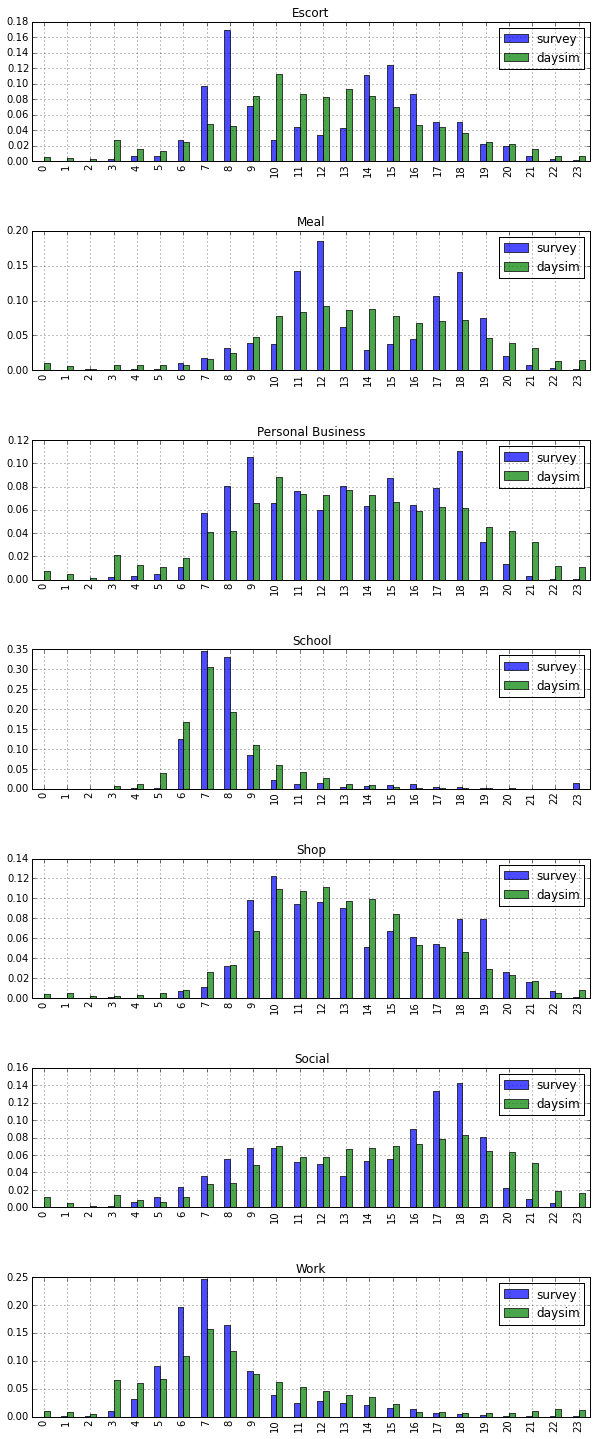

In [33]:
fig1 = plt.figure(figsize=(100,100), )
plt.subplots_adjust(hspace=.5)
plt.axis('off')
plt.title('')
chrt = 0
for col in survey_pivot_df.columns:
    chrt += 1
    ax = fig1.add_subplot(len(survey_pivot_df.columns),1,chrt)
    
    # only show legend for a single chart
#     if chrt == 1:
#         legend=True
#     else:
#         legend=False
    
    tempdf = df[[col+'_survey',col+'_daysim']]
    tempdf.columns = ['survey','daysim']
    tempdf.plot(kind='bar', ax=ax, alpha=0.7, legend=True, figsize=(10,25), sharex=False)
    ax.set_title(col)
    ax.set_xlabel('')

# Transit Only
-----

## Transit Tour Origin Departure Hour

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


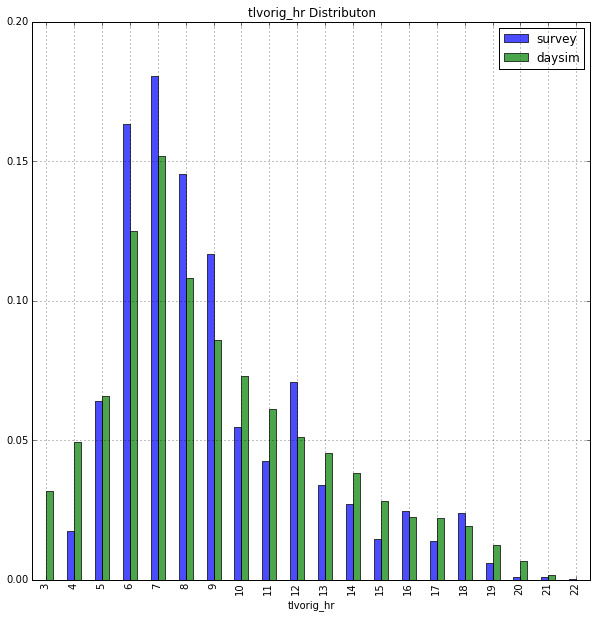

In [20]:
survey_transit_tours = hhmm_to_mam(survey_transit_tours, ['tlvorig','tardest','tlvdest','tarorig'])
daysim_transit_tours = hhmm_to_mam(daysim_transit_tours, ['tlvorig','tardest','tlvdest','tarorig'])

distribution_plot(survey_transit_tours, daysim_transit_tours, 'tlvorig_hr', expfac='toexpfac')

## Transit Tour Departure Time by Purpose

In [34]:
survey_pivot_df = pd.pivot_table(survey_transit_tours,columns='pdpurp', index='tlvorig_hr', values='toexpfac', aggfunc='sum')
survey_pivot_df = survey_pivot_df/(survey_pivot_df.sum())

daysim_pivot_df = pd.pivot_table(daysim_transit_tours,columns='pdpurp', index='tlvorig_hr', values='toexpfac', aggfunc='sum')
daysim_pivot_df = daysim_pivot_df/(daysim_pivot_df.sum())

df = survey_pivot_df.join(daysim_pivot_df,lsuffix='_survey',rsuffix='_daysim')

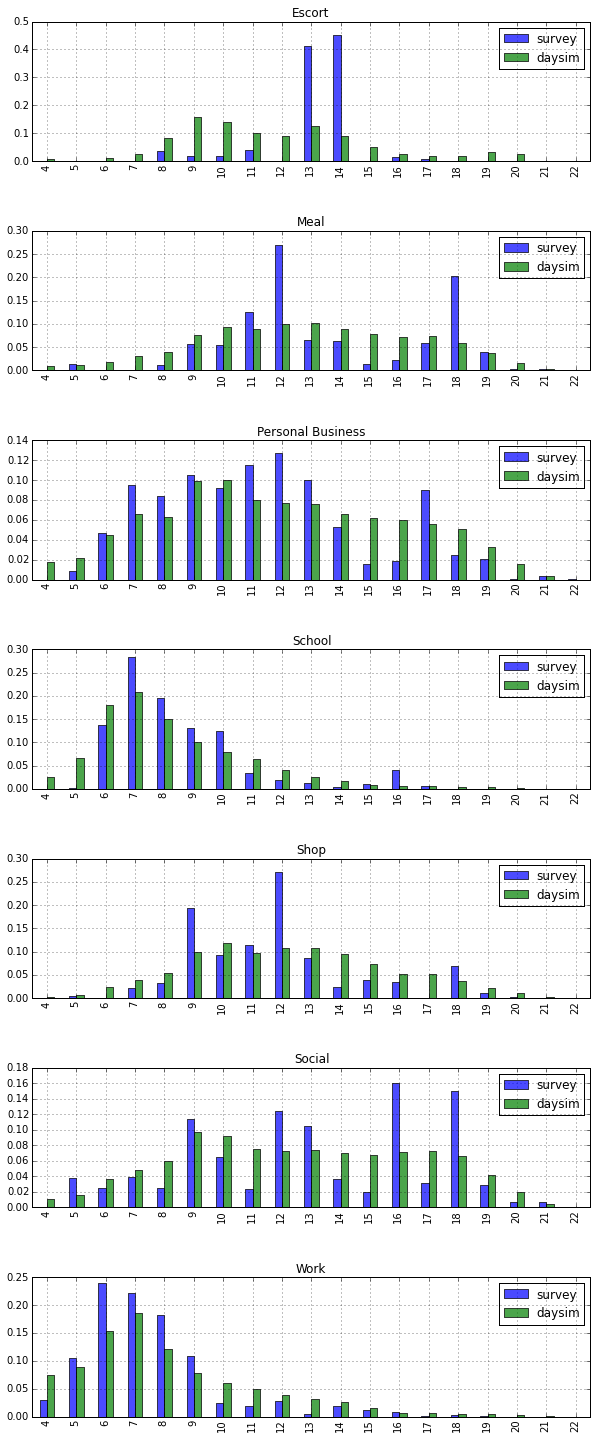

In [35]:
fig1 = plt.figure(figsize=(100,100), )
plt.subplots_adjust(hspace=.5)
plt.axis('off')
plt.title('')
chrt = 0
for col in survey_pivot_df.columns:
    chrt += 1
    ax = fig1.add_subplot(len(survey_pivot_df.columns),1,chrt)
    
    # only show legend for a single chart
#     if chrt == 1:
#         legend=True
#     else:
#         legend=False
    
    tempdf = df[[col+'_survey',col+'_daysim']]
    tempdf.columns = ['survey','daysim']
    tempdf.plot(kind='bar', ax=ax, alpha=0.7, legend=True, figsize=(10,25), sharex=False)
    ax.set_title(col)
    ax.set_xlabel('')